In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Original Training Data Distribution:
Training_Program
0    23
2    21
3    20
1    18
4    16
5    15
6    10
7    10
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
3    23
5    23
4    23
1    23
6    23
2    23
0    23
7    23
Name: count, dtype: int64
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'class_weight': None, 'C': 1000}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.75      0.75      0.75         8
           2       0.29      0.44      0.35         9
           3       0.25      0.25      0.25         8
           4       0.40      0.29      0.33         7
           5       0.33      0.29      0.31         7
           6       0.80      0.80      0.80         5
           7       1.00      0.75      0.86         4

    accuracy                         

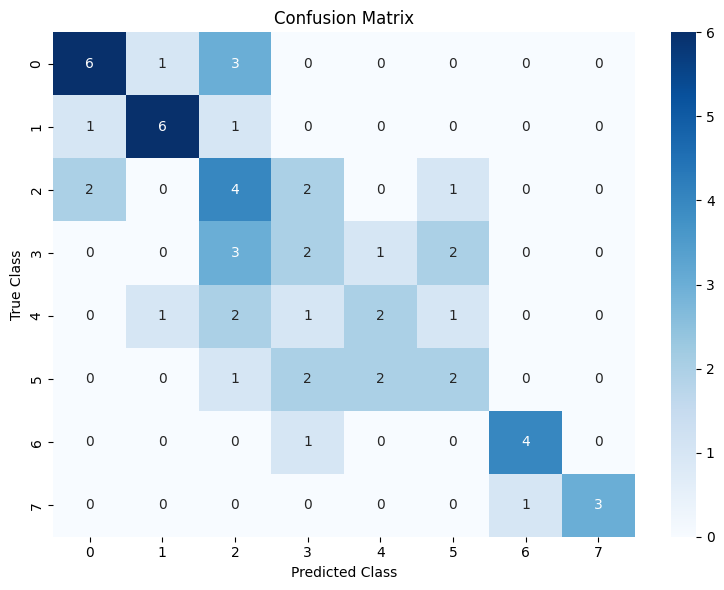

Permutation Importance for SVM:
              Feature  Importance
5   sports_experience    0.129885
3                 age    0.105172
6            body_fat    0.087931
9         W/Hip_Ratio    0.076437
7               goals    0.075862
4       resting_pulse    0.068966
16              hip_c    0.056897
14         left_arm_c    0.047701
10     W/Height_Ratio    0.045977
13        right_arm_c    0.038506
12            chest_c    0.036782
1              height    0.031609
15            waist_c    0.030460
18          lower_leg    0.028736
17        upper_leg_c    0.022989
11         shoulder_c    0.021839
8                 BMI    0.020690
2              weight    0.010920
0              gender   -0.011494


C:\Users\licop\AppData\Local\Temp\ipykernel_18516\2707256497.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=svm_importances, x='Importance', y='Feature', palette='viridis')


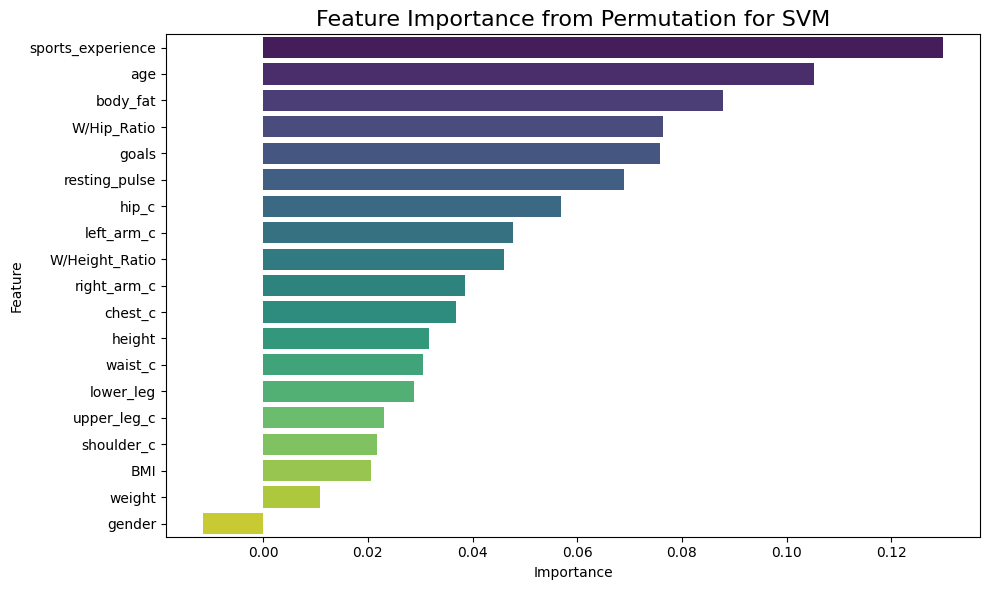

In [12]:
# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program", "surgeries", "chronic_conditions"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=12)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define the SVM model
svm_model = SVC(probability=True, random_state=12)

# Define hyperparameters for optimization
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01,'scale', 'auto'],
    'degree': [2, 3, 4, 5, 6],
    'class_weight': [None, 'balanced']
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=4,
    random_state=12,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters:", random_search.best_params_)

# Evaluate the best model
best_svm = random_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Calculate Permutation Importance
perm_importance_svm = permutation_importance(best_svm, X_test, y_test, n_repeats=30, random_state=42)

# Store permutation importance in a DataFrame
svm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance_svm.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Permutation Importance for SVM:")
print(svm_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=svm_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Permutation for SVM', fontsize=16)
plt.tight_layout()
plt.show()